In [1]:
import json
import torch
import torch.nn.functional as F
import os
import sys
import random
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from importlib import reload

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

os.chdir('/home/nico/dev/projects/ai/musai')

sys.path.append('./src/tools')

import tokenizer

reload(tokenizer)

from tokenizer import get_tokenizer, parse_bpe_tokens, TOKEN_PARAMS_NAME

TOKENS_PATH = '/home/nico/data/ai/models/midi/sequences/bpe'
TOKENS_FILE_PATHS = list(Path(TOKENS_PATH).glob('*.json'))


In [2]:
device

device(type='cuda', index=0)

In [3]:
TOKENIZER = get_tokenizer(params=f'{TOKENS_PATH}/{TOKEN_PARAMS_NAME}')
PITCHES = [v for k, v in TOKENIZER.vocab.items() if 'Pitch' in k]

2023-06-17 17:21:54.446 | INFO     | tokenizer:get_tokenizer:180 - Tokenizer initialized. Using MMM


In [4]:
len(TOKENIZER)

635

In [24]:
logger.info('Semantical processing: {collection_size} documents', collection_size=len(
    TOKENS_FILE_PATHS))

random.shuffle(TOKENS_FILE_PATHS)

bag_of_hists = []

for token_file in tqdm(list(TOKENS_FILE_PATHS)):
    try:
        tokens = json.load(open(token_file, 'r'))['ids']

        # filter tokens
        # tokens = [t for t in tokens if t in PITCHES]
        
        # extract pitch histogram
        tensor = torch.tensor(tokens).to(torch.float)
        # tensor_hist = tensor.histc(bins=len(PITCHES))
        tensor_hist = tensor.histc(bins=len(TOKENIZER))

        bag_of_hists.append(tensor_hist)
    except KeyboardInterrupt:
        break
    except Exception as e:
        logger.error(e)

bag_of_hists = torch.stack(bag_of_hists)
bag_of_hists_normalized = F.normalize(bag_of_hists, dim=0)


2023-06-17 18:03:26.322 | INFO     | __main__:<module>:1 - Semantical processing: 2992 documents
100%|█████████████████████████████████████████████████████| 2992/2992 [00:06<00:00, 437.40it/s]


In [25]:
means = torch.stack([torch.mean(v) for v in bag_of_hists_normalized.t()])
distances = torch.FloatTensor([torch.mean((v - means) ** 2).item()
             for v in bag_of_hists_normalized])

distances.shape

torch.Size([2992])

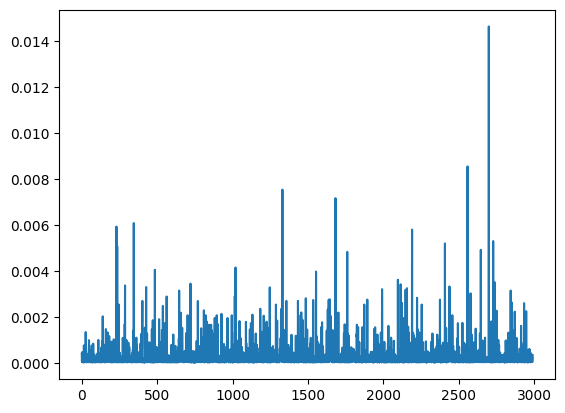

In [26]:
mean = torch.mean(distances)
plt.plot(distances)

In [30]:
ixs = [x[0] for x in list(filter(lambda d: d[1]<=(mean+(mean*.15)) and d[1] >= (mean-(mean*.15)), enumerate(distances)))]

random.shuffle(ixs)

TOKENS_FILE_PATHS[ixs[0]]

PosixPath('/home/nico/data/ai/models/midi/sequences/bpe/130_remember_the_fallen_mid.json')

In [28]:
print('%.8f' % float(mean))

0.00031965
